<h2 align="center">Data Science Lab: Process and Methods</h2>
<h2 align="center">Politecnico di Torino</h2>
<h2 align="center">Project Assignment September Call, A.Y. 2022/2023</h2>

    
                Target = JWMNP( Commute time to work ) 
                
                • Aim goal : I built a regression pipeline to predict the commuting time (in minutes) of each person in the evaluation set.
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from pathlib import Path
from pandas import read_csv
import matplotlib.pyplot as plt

# File system manangement
import os
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Sklearn processing
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.model_selection import  StratifiedShuffleSplit,ShuffleSplit,RepeatedStratifiedKFold,StratifiedKFold

# Sklearn regression algorithms regression models.
from sklearn.model_selection import RepeatedKFold,ShuffleSplit,StratifiedKFold,KFold,train_test_split,cross_val_score
from sklearn.svm import SVC ,LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge,Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Sklearn regression model evaluation function
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score,mean_absolute_error

#Grid Search
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder

# Loading Dataset

In [198]:
##################### HOMEWORK ######################### 
#Find the Directory of current working directory
path1='development.csv'

# load all data from file that we will use for your homework
dev_tsv = pd.read_csv(path1,sep=',')
data = dev_tsv.copy()
# resetting index
data.reset_index(inplace = True, drop = True)
# sort by index labels
data.sort_index(axis = 0,inplace = True)

In [199]:
# What is the shape of the dataset?
print("Input data has {} rows and {} columns".format(len(data), len(data.columns)))

Input data has 104642 rows and 26 columns


# Overview data of the original dataframe

In [6]:
def make_df_dtype(data):
    '''
    Makes a dataframe to overview data of the original dataframe, column by column.
    Each resulting row provides info dealing with each column:
    - data type
    - data specimen
    - number of unique values
    - share of missing values
    
    Args:
        data (DataFrame): The DataFrame to work with.
        
    Returns:
        resulting DataFrame        
    '''
    
    cols, dtype_col, specimens, nunique, null_share = [], [], [], [], []
    for column in data:
        cols.append(column)
        
        this_dtype = data[column].dtype
        dtype_col.append(this_dtype)
        
        specimen = data.loc[data[column].first_valid_index(), column]
        specimens.append(specimen)
        
        nunique.append(data[column].nunique())
        
        null_sum = data[column].isna().sum()
        null_to_len = null_sum / len(data[column])
        null_share.append(f'{null_to_len:.2%}')
        
    df = pd.DataFrame(list(zip(dtype_col,
                               specimens,
                               nunique,
                              null_share)),
                      index=cols)    
    df.columns=['dtype',
                'specimen',
                'nunique',
               '%null_values']
 
    return df

In [7]:
make_df_dtype(data)

,dtype,specimen,nunique,%null_values
Id,int64,0.0,104642,0.00%
COW,float64,1.0,8,0.00%
SCHL,float64,19.0,24,0.00%
MAR,float64,5.0,5,0.00%
OCCP,float64,4200.0,529,0.00%
POBP,float64,6.0,218,0.00%
WKHP,float64,60.0,97,0.00%
SEX,float64,1.0,2,0.00%
RAC1P,float64,1.0,9,0.00%
MIG,float64,1.0,3,0.00%


Sur mon Jupiter Notebook, je souhaite insérer l'information suivante :

La visualisation de notre jeu de données nous pousse à faire les observations suivantes :
1. Aucune des colonnes ne contient de valeurs nulles ou manquantes.
2. Le dataset est composé uniquement de colonnes de type float ou int.
3. Certaines colonnes contiennent un grand nombre de valeurs uniques.

Dans l'étape suivante, nous allons séparer les données numériques de type catégorique de celles qui ne le sont pas.


In [13]:
def separate_columns_by_distinct_values(data, max_distinct_values):
    list_columns = [x for x in list(data.columns) if x not in ['Id','JWMNP']]
    columns_with_max_distinct_values = []
    columns_with_more_than_max_distinct_values = []

    for feature in list_columns:
        unique_values = data[feature].nunique()
        if unique_values <= max_distinct_values:
            columns_with_max_distinct_values.append((feature, unique_values))
        else:
            columns_with_more_than_max_distinct_values.append((feature, unique_values))

    return columns_with_max_distinct_values, columns_with_more_than_max_distinct_values

# Exemple d'utilisation : séparer les colonnes avec un maximum de 5 valeurs distinctes
max_distinct_values = 15
cols_with_max_distinct, cols_with_more_than_max_distinct = separate_columns_by_distinct_values(data, max_distinct_values)

# Afficher les résultats
print(f"Colonnes avec un maximum de {max_distinct_values} valeurs distinctes :")
for col, num_unique in cols_with_max_distinct:
    print(f"{col} ({num_unique} valeurs distinctes)")

print("\nColonnes avec plus de 15 valeurs distinctes :")
for col, num_unique in cols_with_more_than_max_distinct:
    print(f"{col} ({num_unique} valeurs distinctes)")

Colonnes avec un maximum de 15 valeurs distinctes :
COW (8 valeurs distinctes)
MAR (5 valeurs distinctes)
SEX (2 valeurs distinctes)
RAC1P (9 valeurs distinctes)
MIG (3 valeurs distinctes)
HICOV (2 valeurs distinctes)
PAOC (5 valeurs distinctes)
PUBCOV (2 valeurs distinctes)
VPS (13 valeurs distinctes)
DEAR (2 valeurs distinctes)
MIL (4 valeurs distinctes)
FER (3 valeurs distinctes)
ENG (5 valeurs distinctes)
OC (2 valeurs distinctes)
FDEYEP (2 valeurs distinctes)

Colonnes avec plus de 15 valeurs distinctes :
SCHL (24 valeurs distinctes)
OCCP (529 valeurs distinctes)
POBP (218 valeurs distinctes)
WKHP (97 valeurs distinctes)
LANP (119 valeurs distinctes)
PINCP (4469 valeurs distinctes)
MIGSP (94 valeurs distinctes)
JWAP (285 valeurs distinctes)
JWDP (150 valeurs distinctes)


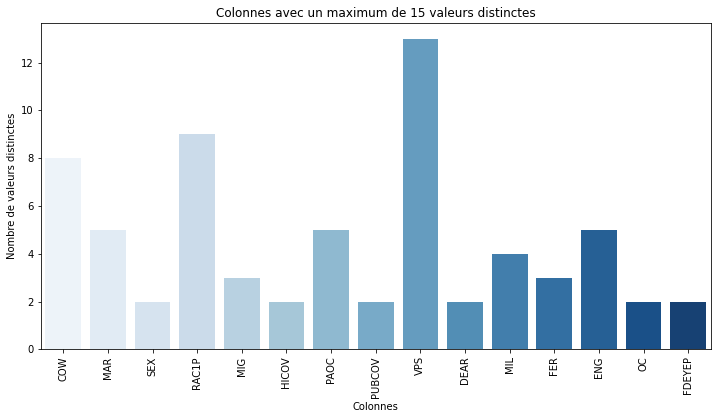

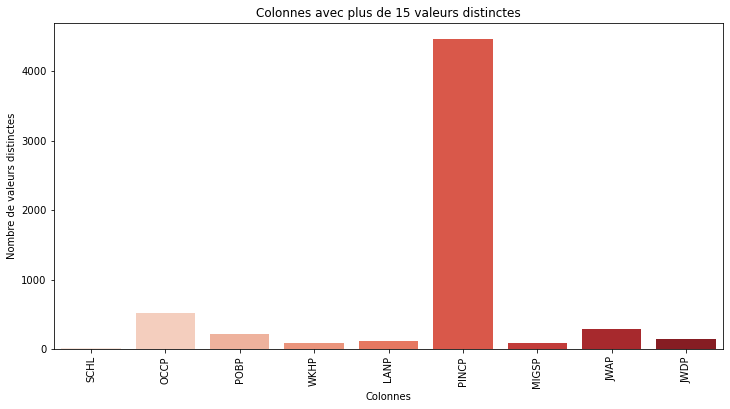

In [29]:
def plot_columns_by_distinct_values(cols_with_max_distinct, cols_with_more_than_max_distinct, max_distinct_values):
    columns_max_distinct_names, columns_max_distinct_values = zip(*cols_with_max_distinct)
    columns_more_than_max_distinct_names, columns_more_than_max_distinct_values = zip(*cols_with_more_than_max_distinct)

    columns_max_distinct_values = [int(value) for value in columns_max_distinct_values]
    columns_max_distinct_names = list(columns_max_distinct_names)
    
    columns_more_than_max_distinct_values = [int(value) for value in columns_more_than_max_distinct_values]
    columns_more_than_max_distinct_names = list(columns_more_than_max_distinct_names)
    
    
    # Créez un diagramme à barres pour les colonnes avec un maximum de max_distinct_values valeurs distinctes
    plt.figure(figsize=(12, 6))
    sns.barplot(x=columns_max_distinct_names, y=columns_max_distinct_values, palette="Blues")
    plt.title(f"Colonnes avec un maximum de {max_distinct_values} valeurs distinctes")
    plt.xlabel("Colonnes")
    plt.ylabel("Nombre de valeurs distinctes")
    plt.xticks(rotation=90)  # Rotation des noms de colonnes pour une meilleure lisibilité
    plt.show()

    # Créez un diagramme à barres pour les colonnes avec plus de max_distinct_values valeurs distinctes
    plt.figure(figsize=(12, 6))
    sns.barplot(x=columns_more_than_max_distinct_names, y=columns_more_than_max_distinct_values, palette="Reds")
    plt.title(f"Colonnes avec plus de {max_distinct_values} valeurs distinctes")
    plt.xlabel("Colonnes")
    plt.ylabel("Nombre de valeurs distinctes")
    plt.xticks(rotation=90)  # Rotation des noms de colonnes pour une meilleure lisibilité
    plt.show()
# Utilisation de la fonction
plot_columns_by_distinct_values(cols_with_max_distinct, cols_with_more_than_max_distinct, max_distinct_values)


In [30]:
numerical_features=[col[0] for col in cols_with_more_than_max_distinct]
numerical_features

['SCHL', 'OCCP', 'POBP', 'WKHP', 'LANP', 'PINCP', 'MIGSP', 'JWAP', 'JWDP']

In [ ]:
numerical_features=[col[0] for col in cols_with_more_than_max_distinct]
numerical_features

# Investigating the Target Column

In [31]:
# Supposons que vous ayez déjà extrait vos données dans un objet 'data'
unique, counts = np.unique(data.JWMNP, return_counts=True)
ds = {'label': list(unique), 'count': list(counts)}
df_unique = pd.DataFrame(ds)

# Sort df_unique by the 'count' column in descending order
df_unique_sorted = df_unique.sort_values(by='count', ascending=False)
df_unique_sorted.head()

,label,count
29,30.0,15714
14,15.0,15414
19,20.0,15075
9,10.0,11817
24,25.0,6724


# Visualisation des 20 Valeurs de la colonne Target l les plus fréquents

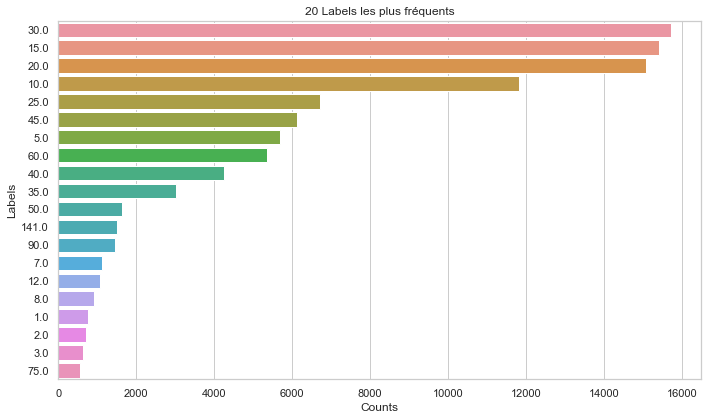

In [39]:
# Supposons que vous ayez déjà préparé le DataFrame df_unique_sorted
# avec les données triées par ordre décroissant de 'count'
# Sélectionnez les 20 labels les plus fréquents

def plot_top_n_labels(df, n):
    top_n_labels = df.head(n)
    
    # Définissez le style de Seaborn (facultatif)
    sns.set(style="whitegrid")

    # Créez un graphique à barres en utilisant Seaborn avec les n labels les plus fréquents
    plt.figure(figsize=(10, 6))
    sns.barplot(x="count", y="label", data=top_n_labels, orient='h', order=top_n_labels['label'])  # Utilisez 'orient' pour un graphique horizontal

    # Ajoutez des étiquettes et un titre
    plt.xlabel('Counts')
    plt.ylabel('Labels')
    plt.title(f'{n} Labels les plus fréquents')

    # Affichez le graphique
    plt.tight_layout()
    plt.show()

# Utilisation de la fonction avec n=20
plot_top_n_labels(df_unique_sorted, 20)


# Visualisation des 20 Valeurs de la colonne target les moins fréquents 

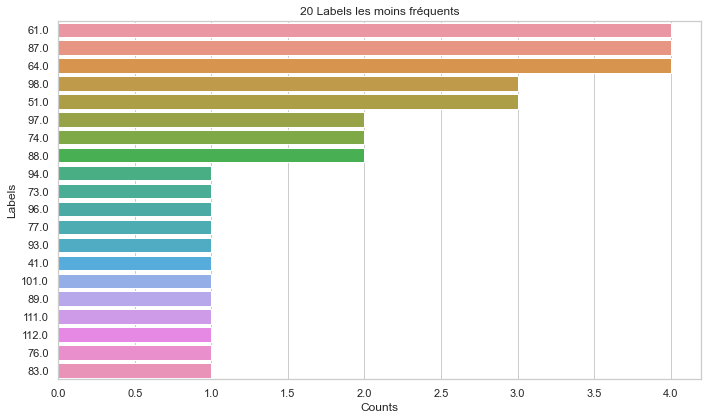

In [38]:
# Sélectionnez les 20 labels les moins fréquents (en utilisant tail() au lieu de head())
def plot_least_frequent_labels(data, n_labels):
    # Sélectionnez les n labels les moins fréquents (en utilisant tail() au lieu de head())
    bottom_n_labels = data.tail(n_labels)

    # Définissez le style de Seaborn (facultatif)
    sns.set(style="whitegrid")

    # Créez un graphique à barres en utilisant Seaborn avec les n labels les moins fréquents
    plt.figure(figsize=(10, 6))
    sns.barplot(x="count", y="label", data=bottom_n_labels, orient='h', order=bottom_n_labels['label'])  # Utilisez 'orient' pour un graphique horizontal

    # Ajoutez des étiquettes et un titre
    plt.xlabel('Counts')
    plt.ylabel('Labels')
    plt.title(f'{n_labels} Labels les moins fréquents')

    # Affichez le graphique
    plt.tight_layout()
    plt.show()

# Utilisation de la fonction avec n=20
n_labels = 20
plot_least_frequent_labels(df_unique_sorted, n_labels)


In [225]:
def remove_least_frequent_values(df, target_col, n):
    """
    Retire les 'n' valeurs les moins fréquentes de la colonne cible d'un DataFrame.

    Args:
        df (DataFrame): Le DataFrame contenant les données.
        target_col (str): Le nom de la colonne cible.
        n (int): Le nombre de valeurs à conserver.

    Returns:
        DataFrame: Un nouveau DataFrame avec les 'n' valeurs les plus fréquentes de la colonne cible.
    """
    # Comptez le nombre d'occurrences de chaque valeur dans la colonne cible
    value_counts = df[target_col].value_counts()

    # Triez les valeurs en fonction de leur fréquence
    sorted_values = value_counts.sort_values(ascending=False)

    # Sélectionnez les 'n' valeurs les plus fréquentes
    top_n_values = sorted_values.head(n)

    # Filtrez le DataFrame original pour exclure les lignes contenant les 'n' valeurs les moins fréquentes
    filtered_df = df[df[target_col].isin(top_n_values.index)]

    return filtered_df


def replace_low_frequency_values(df, target_col, m):
    """
    Replace values in the target column with np.nan if their frequency is less than 'm'.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - target_col (str): The name of the target column.
    - m (int): The threshold frequency. Values with frequency less than 'm' will be replaced with np.nan.

    Returns:
    - pd.DataFrame: A new DataFrame with values in the target column replaced by np.nan if their frequency is less than 'm'.
    """
    # Count the occurrences of each value in the target column
    value_counts = df[target_col].value_counts()

    # Replace values with frequency less than 'm' with np.nan
    df[target_col] = df[target_col].apply(lambda x: x if value_counts.get(x, 0) >= m else np.nan)

    return df


# Recherchez les anomalies dans la colonne target.

<img src="fotoOutliers.png" alt="Texte de remplacement" width="580"/>

In [110]:
# Method 1: Detecting and Treating Outliers.
# Removing outliers from data using Python and Pandas.
def get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(first_quartile) # xth percentile / 1st quartile
    q3 = df_in[col_name].quantile(third_quartile) # yth percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-(1.5*iqr) # The minimum value or the |- marker in the box plot
    maximum = q3+(1.5*iqr) # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

def get_iqr_text_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    text = f"median={median:.2f}, q1={q1:.2f}, q3={q3:.2f}, iqr={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

def remove_outliers_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    _, _, _, _, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

def count_outliers_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    _, _, _, _, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    return df_outliers.shape[0]

#Replacing Outliers with nan Values
def Replace_Outliers_with_nan_Specifying_quartile(df_in, col_name,first_quartile,third_quartile):
    median, q1, q3, iqr, minimum, maximum = get_iqr_values_Specifying_quartile(df_in, col_name,first_quartile,third_quartile)
    df_in.loc[df_in[col_name] < minimum,col_name] = np.nan
    df_in.loc[df_in[col_name] > maximum,col_name] = np.nan
    return df_in    

def box_and_whisker_Specifying_quartile(df, col_name,first_quartile,third_quartile):
    title = get_iqr_text_Specifying_quartile(df, col_name,first_quartile,third_quartile)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    
    sns.distplot(df[col_name], ax=axes[0])
    axes[0].set_title(f'Distribution de {col_name}')

    sns.boxplot(x=df[col_name], ax=axes[1])
    axes[1].set_title(f'Informations : {title}')
    
    plt.tight_layout()
    plt.show()

Informations de JWMNP:  median=20.00, q1=15.00, q3=30.00, iqr=15.00, minimum=-7.50, maximum=52.50


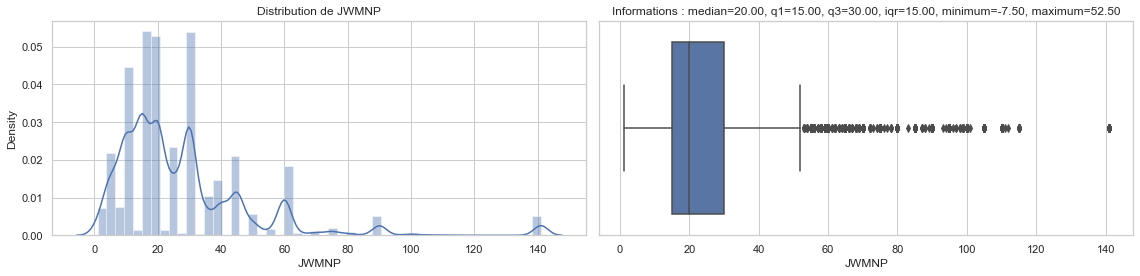

Count outliers in the target column:  10610


In [159]:
q1 ,q3 ,feature = 0.25, 0.75, 'JWMNP'
print("Informations de JWMNP: ",get_iqr_text_Specifying_quartile(data, feature,q1, q3))

box_and_whisker_Specifying_quartile(data, feature,q1, q3)

print("Count outliers in the target column: ",count_outliers_Specifying_quartile(data, feature,q1, q3))

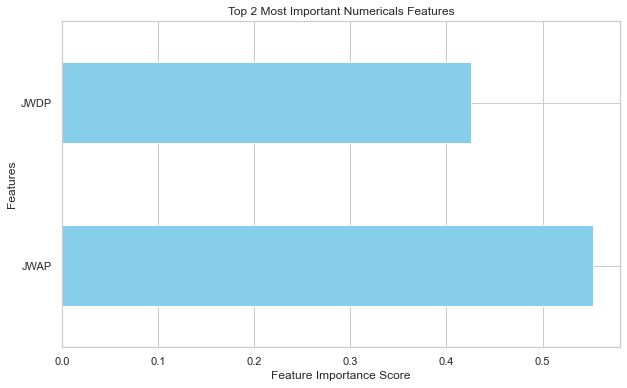

In [108]:
def plot_top_features(data, target_column, numerical_columns, threshold=0.30):
    """
    Plot the top N most important features based on feature importance scores from an Extra Trees Regressor model.
    
    Args:
    data (DataFrame): The DataFrame containing the data.
    target_column (str): The name of the target column.
    numerical_columns (list): List of numerical column names in the data.
    threshold (float, optional): The threshold for feature importance. Features with importance scores above this threshold will be considered.
    num_features (int, optional): The number of top features to plot.
    """
    # Extract numerical features and target variable
    X, y = data[numerical_columns], data[target_column]
    
    # Create an Extra Trees Regressor model
    model = ExtraTreesRegressor()
    
    # Fit the model to the data
    model.fit(X, y)
    
    # Calculate feature importances using the trained model
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # Select features above the threshold
    selected_features = feat_importances[feat_importances > threshold]
    
    num_features = len(selected_features)
    
    # Select the top N most important features
    top_features = selected_features.nlargest(num_features)
    
    # Plot the top N most important features in a horizontal bar chart
    plt.figure(figsize=(10, 6))
    top_features.plot(kind="barh", color="skyblue")
    plt.title(f"Top {num_features} Most Important Numericals Features")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.show()

# Exemple d'utilisation :
# Remplacez 'votre_dataframe' par le nom de votre DataFrame, 'JWMNP' par le nom de votre colonne cible,
# et 'numerical_columns' par la liste des noms de vos colonnes numériques.
plot_top_features(data, 'JWMNP', numerical_features, threshold=0.30)

In [112]:
target = 'JWMNP'
best_features = ['JWAP', 'JWDP']

In [148]:
def Makebaselinemodels():
    # Liste des modèles de base
    Models = [ExtraTreesRegressor(),RandomForestRegressor(),DecisionTreeRegressor(),KNeighborsRegressor()]
    return Models

def split_dataset(X, y, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        shuffle=True,random_state=random_state)
    return X_train, X_test, y_train, y_test


def evaluate_regressors(X, y, regressors, threshold=0.30, random_state=402):
    results = []
    
    X_train, X_test, y_train, y_test = split_dataset(X, y, threshold)
    
    for model in regressors:
        start = time()
        model.fit(X_train, y_train)
        train_time = time() - start
        start = time()
        y_pred_arr = model.predict(X_test)
        y_pred = [round(x, 0) for x in y_pred_arr]
        predict_time = time() - start 
        explained_variance = explained_variance_score(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': str(model),
            'R2 Score': r2,
            #'Training Time': train_time,
            #'Prediction Time': predict_time,
            'Expl. Variance': explained_variance
        })
    
    # Créez un DataFrame à partir des résultats
    results_df = pd.DataFrame(results)
    
    # Affichez les résultats sous forme de tableau
    display(results_df)

In [150]:
# Liste des modèles de base
regressors = Makebaselinemodels()

# Utilisation de la fonction
X, y, threshold = data[best_features], data[target], 0.30

evaluate_regressors(X, y, regressors)

,Model,R2 Score,Expl. Variance
0,ExtraTreesRegressor(),0.996248,0.996253
1,RandomForestRegressor(),0.995692,0.995703
2,DecisionTreeRegressor(),0.995198,0.995204
3,KNeighborsRegressor(),0.992163,0.992169


In [149]:
def evaluate_regressors_with_filtering(data, target_col, n, threshold=0.30, random_state=402):
    filtered_df = remove_least_frequent_values(data, target_col, n)
    
    print("Affichage de la forme du DataFrame Avant: ", data.shape) 
    print("Affichage de la forme du DataFrame Après: ", filtered_df.shape)  
    
    X, y, threshold = filtered_df[best_features], filtered_df[target_col], 0.30

    # Liste des modèles de base
    regressors = Makebaselinemodels()

    # Utilisation de la fonction
    X, y, threshold = filtered_df[best_features], filtered_df[target], 0.30

    evaluate_regressors(X, y, regressors)
    
    return filtered_df
    

# Exemple d'utilisation :
# Remplacez 'votre_dataframe', 'target_col', 'votre_regressors_list', et 'n' par les valeurs appropriées.
filtered_df = data.copy()
filtered_df = evaluate_regressors_with_filtering(filtered_df, target, n=60)

Affichage de la forme du DataFrame Avant:  (104642, 26)
Affichage de la forme du DataFrame Après:  (104449, 26)


,Model,R2 Score,Expl. Variance
0,ExtraTreesRegressor(),0.996155,0.996160
1,RandomForestRegressor(),0.995797,0.995806
2,DecisionTreeRegressor(),0.995343,0.995349
3,KNeighborsRegressor(),0.992314,0.992319


In [155]:
def evaluate_n_values(df, best_features, target_col, n_values, threshold=0.30):
    
    results = []
    for n in n_values:
        filtered_df = remove_least_frequent_values(df, target_col, n)
        X_filtered, y_filtered = filtered_df[best_features], filtered_df[target_col]
        X_train, X_test, y_train, y_test = split_dataset(X_filtered, y_filtered, threshold)
        model = ExtraTreesRegressor()
        model.fit(X_train, y_train)
        y_pred_arr = model.predict(X_test)
        y_pred = [round(x, 0) for x in y_pred_arr]
        r2 = r2_score(y_test, y_pred)
        #explained_variance = explained_variance_score(y_filtered, y_pred)
        results.append({'n': n, 'R2 Score': r2, 'Shape': filtered_df.shape[0]})

    # Créez un DataFrame à partir des résultats
    results_df = pd.DataFrame(results)

    # Affichez les résultats
    print(results_df)

    # Trouvez la valeur de n avec le meilleur R2 Score
    best_n = results_df.loc[results_df['R2 Score'].idxmax()]['n']

    # Utilisez Seaborn pour visualiser R2 Score en fonction de n
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='n', y='R2 Score', data=results_df, marker='o')
    plt.xlabel('Number of Values (n)')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs Number of Values')
    plt.show()

    print(f"La meilleure valeur de n avec le meilleur R2 Score est : {best_n}")

     n  R2 Score   Shape
0   10  0.993520   89192
1   20  0.996848   99560
2   30  0.996466  102666
3   40  0.996425  103800
4   50  0.996260  104219
5   60  0.996241  104449
6   70  0.996259  104554
7   80  0.996505  104610
8   90  0.996207  104633
9  100  0.996236  104642


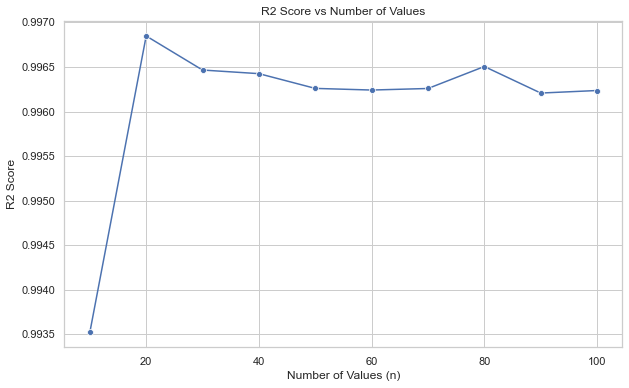

La meilleure valeur de n avec le meilleur R2 Score est : 20.0


In [156]:
n_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  #Input data has 104642 rows and 26 columns
filtered_df = data.copy()
evaluate_n_values(filtered_df,best_features, target, n_values,threshold=0.30)

In [206]:
# Remplacez 'votre_dataframe', 'target_col', 'votre_regressors_list', et 'n' par les valeurs appropriées.
filtered_df = data.copy()
filtered_df = evaluate_regressors_with_filtering(data, target, n=20)
print(f"shape of dataset after applying filter:",filtered_df.shape)

Affichage de la forme du DataFrame Avant:  (104642, 26)
Affichage de la forme du DataFrame Après:  (99560, 26)


,Model,R2 Score,Expl. Variance
0,ExtraTreesRegressor(),0.997237,0.997237
1,RandomForestRegressor(),0.996783,0.996784
2,DecisionTreeRegressor(),0.996595,0.996595
3,KNeighborsRegressor(),0.993054,0.993060


shape of dataset after applying filter: (99560, 26)


In [234]:
data.shape[0]-99560

5082

In [252]:
lowfrequencies, filtered_clean =  500, data.copy()
filtered_clean = replace_low_frequency_values(filtered_clean, target, lowfrequencies)

# Avant l'application du code
print("Nombre de valeurs nulles avant :")
print(data[target].isnull().sum())

# Après l'application du code
print("Nombre de valeurs nulles après :")
print(filtered_clean[target].isnull().sum())

Nombre de valeurs nulles avant :
0
Nombre de valeurs nulles après :
5082


In [254]:
def knn_imputation_with_tuning(filtered_clean, features_to_treat, threshold, k_range, model):
    R2score = []

    for i in range(1, k_range):
        print(f"Entraînement avec k = {i}")
        knn = KNNImputer(n_neighbors=i)
        X = filtered_clean[features_to_treat].copy()
        X = pd.DataFrame(knn.fit_transform(X), columns=features_to_treat)
        valeurs = X.isnull().sum().sum()
        print("Nombre de valeurs nulles dans le dataset après imputation :", valeurs)
        
        if valeurs == 0:
            print("Aucune valeur nulle après l'imputation. Entraînement du modèle...")
            # Entraînez le modèle avec les données imputées
            X, y =  X.drop('JWMNP', axis=1), X['JWMNP']
            X_train, X_test, y_train, y_test = split_dataset(X, y, threshold)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            R2score.append(r2_score(y_test, y_pred))
            
        else:
            print(f"Il reste des valeurs nulles pour k = {i}. Le modèle ne sera pas entraîné.")
            R2score.append(0)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, k_range), R2score, color='blue', linestyle='dashed', 
             marker='o', markerfacecolor='red', markersize=10)
    plt.title('R2 vs. K Value')
    plt.xlabel('K')
    plt.ylabel('R2')
    plt.show()

    min_r2_score = min(R2score)
    min_k = R2score.index(min_r2_score) + 1
    max_r2_score = max(R2score)
    max_k = R2score.index(max_r2_score) + 1

    print("Minimum R2 score:", min_r2_score, "at K =", min_k)
    print("Maximum R2 score:", max_r2_score, "at K =", max_k)

    return min_k, max_k

Entraînement avec k = 1
Nombre de valeurs nulles dans le dataset après imputation : 0
Aucune valeur nulle après l'imputation. Entraînement du modèle...
Entraînement avec k = 2
Nombre de valeurs nulles dans le dataset après imputation : 0
Aucune valeur nulle après l'imputation. Entraînement du modèle...
Entraînement avec k = 3
Nombre de valeurs nulles dans le dataset après imputation : 0
Aucune valeur nulle après l'imputation. Entraînement du modèle...
Entraînement avec k = 4
Nombre de valeurs nulles dans le dataset après imputation : 0
Aucune valeur nulle après l'imputation. Entraînement du modèle...
Entraînement avec k = 5
Nombre de valeurs nulles dans le dataset après imputation : 0
Aucune valeur nulle après l'imputation. Entraînement du modèle...


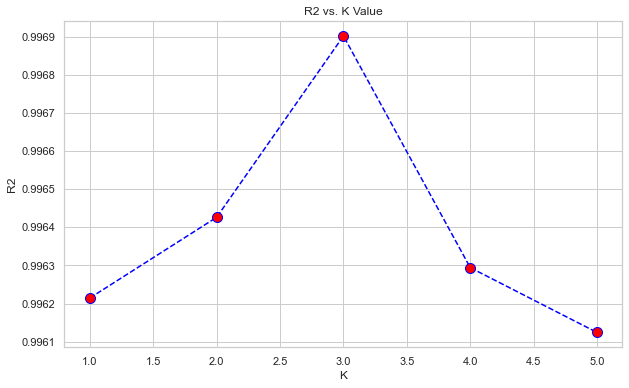

Minimum R2 score: 0.9961239582652744 at K = 5
Maximum R2 score: 0.9969027087586267 at K = 3


In [255]:
features_to_treat = ['JWAP', 'JWDP', 'JWMNP']
threshold = 0.3
k_range = 6  # Vous pouvez ajuster cette plage en fonction de votre besoin
model = YourModel()  # Remplacez YourModel par votre modèle réel

min_k, max_k = knn_imputation_with_tuning(filtered_clean, features_to_treat, threshold, k_range, model)

In [256]:
print("Now we apply the KNN With the best knn value:")
# Initializing KNNImputer
# Avantl'application du code
print("Nombre de valeurs nulles avant :")
print(filtered_clean[target].isnull().sum().sum())

knn = KNNImputer(n_neighbors = max_k)
filtered_clean[features_to_treat] = knn.fit_transform(filtered_clean[features_to_treat])

#Check For Missing Values
print("Missing values in Dataset: ", filtered_clean.isnull().sum().sum())

Now we apply the KNN With the best knn value:
Nombre de valeurs nulles avant :
5082
Missing values in Dataset:  0


     n  R2 Score   Shape
0   10  0.994711   92278
1   20  0.996439  103544
2   30  0.995639  104326
3   40  0.996637  104482
4   50  0.996838  104564
5   60  0.996432  104611
6   70  0.996527  104631
7   80  0.995604  104641
8   90  0.996016  104642
9  100  0.996423  104642


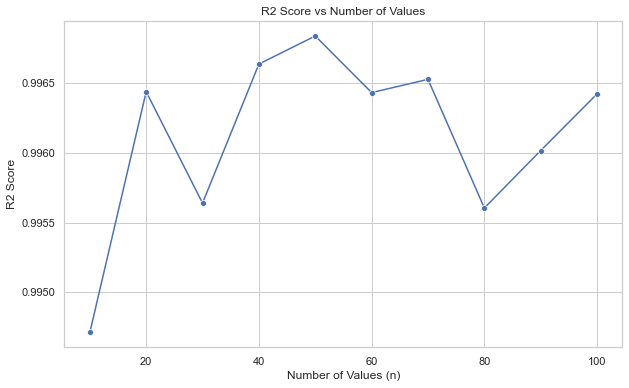

La meilleure valeur de n avec le meilleur R2 Score est : 50.0


In [269]:
n_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  #Input data has 104642 rows and 26 columns
df_filtered = filtered_clean.copy()
evaluate_n_values(df_filtered,best_features, target, n_values,threshold=0.30)

In [257]:
# Liste des modèles de base
regressors = Makebaselinemodels()

# Utilisation de la fonction
X, y, threshold = filtered_clean[best_features], filtered_clean[target], 0.30

evaluate_regressors(X, y, regressors)

,Model,R2 Score,Expl. Variance
0,ExtraTreesRegressor(),0.996383,0.996384
1,RandomForestRegressor(),0.995243,0.995245
2,DecisionTreeRegressor(),0.994349,0.994350
3,KNeighborsRegressor(),0.993614,0.993616


In [270]:
# Remplacez 'votre_dataframe', 'target_col', 'votre_regressors_list', et 'n' par les valeurs appropriées.
df_filtered = filtered_clean.copy()
df_filtered = evaluate_regressors_with_filtering(df_filtered, target, n=50)
print(f"shape of dataset after applying filter:",df_filtered.shape)

Affichage de la forme du DataFrame Avant:  (104642, 26)
Affichage de la forme du DataFrame Après:  (104564, 26)


,Model,R2 Score,Expl. Variance
0,ExtraTreesRegressor(),0.996681,0.996681
1,RandomForestRegressor(),0.996249,0.996249
2,DecisionTreeRegressor(),0.995949,0.995949
3,KNeighborsRegressor(),0.992202,0.992205


shape of dataset after applying filter: (104564, 26)


# Find outliers in the features:

Informations de JWAP:  median=94.00, q1=81.00, q3=110.00, iqr=29.00, minimum=37.50, maximum=153.50
Count outliers in the target column:  13888


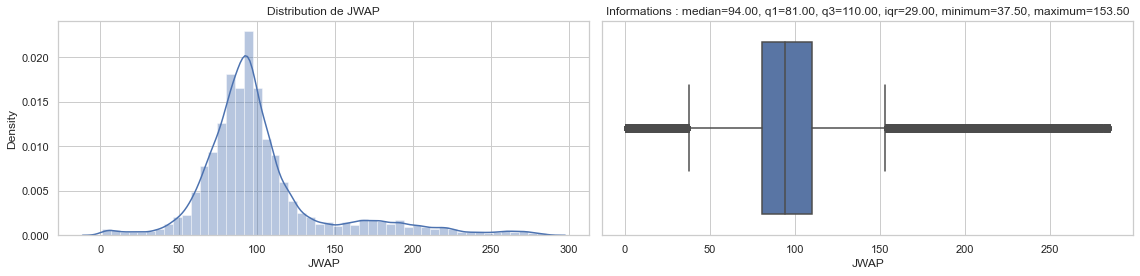


Informations de JWDP:  median=49.00, q1=37.00, q3=67.00, iqr=30.00, minimum=-8.00, maximum=112.00
Count outliers in the target column:  6630


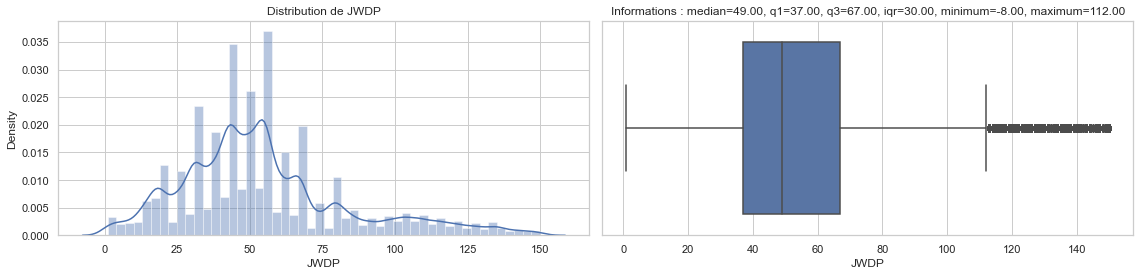

In [163]:
q1, q3 = 0.25,0.75
for feature_name in best_features:

    print(f"Informations de {feature_name}: ",get_iqr_text_Specifying_quartile(data,  feature_name,q1, q3))
    
    print("Count outliers in the target column: ",count_outliers_Specifying_quartile(data, feature_name,q1, q3))
    
    box_and_whisker_Specifying_quartile(data, feature_name,q1, q3)

    
    print()

In [271]:
filtered_df.shape

(99560, 26)

In [274]:
seed = 42  # Remplacez 42 par la valeur de graine aléatoire que vous souhaitez utiliser
def return_R2score(model,X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_arr = model.predict(X_test)
    y_pred = [round(x, 0) for x in y_pred_arr]
    R2score = r2_score(y_test, y_pred)
    return R2score

Mean R2 score for n_splits=2: 0.9964929094089952
Mean R2 score for n_splits=4: 0.9968459442008292
Mean R2 score for n_splits=6: 0.9968949221120185
Mean R2 score for n_splits=8: 0.9969512995314244
Mean R2 score for n_splits=10: 0.996972081634031
Mean R2 score for n_splits=12: 0.9969380760678549


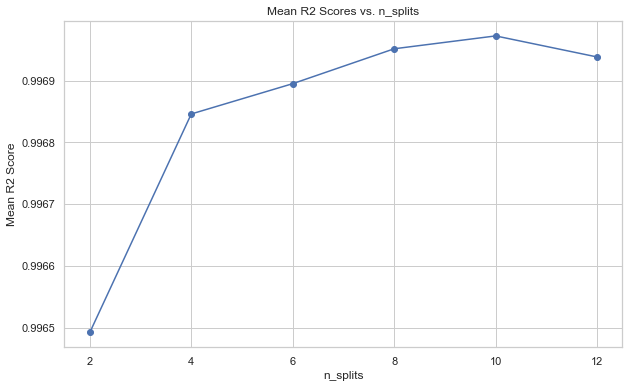

In [275]:
# Initialisation de la liste pour stocker les scores R2
R2scores = []

# Initialisation du modèle que vous souhaitez utiliser (remplacez YourModel par le nom de votre modèle)
model = YourModel()  # Assurez-vous d'avoir importé et défini votre modèle correctement

# Extraction des caractéristiques (features) et de la variable cible (target) du jeu de données d'entraînement
X, y = filtered_df[best_features].values, filtered_df[target].values


#Try StratifiedK-Fold (Stratified5-Fold)
#cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
#Try K-Fold (5-Fold)
#cv = KFold(n_splits=10, random_state=seed, shuffle=True) 

n_splits_values = [2, 4, 6, 8, 10, 12]  # Liste des valeurs de n_splits à tester
R2_scores_mean = []  # Stockera les moyennes des scores R2 pour chaque valeur de n_splits

for n_splits in n_splits_values:
    cv = KFold(n_splits=n_splits, random_state=seed, shuffle=True) 
    R2scores = []

    for train_index, test_index in cv.split(X, y):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=threshold)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        R2score = return_R2score(model, X_train, X_test, y_train, y_test)    
        R2scores.append(R2score)

    mean_R2_score = np.mean(R2scores)
    R2_scores_mean.append(mean_R2_score)

    print(f"Mean R2 score for n_splits={n_splits}: {mean_R2_score}")

# Tracer les résultats de R2 en fonction de n_splits
plt.figure(figsize=(10, 6))
plt.plot(n_splits_values, R2_scores_mean, marker='o', linestyle='-')
plt.title('Mean R2 Scores vs. n_splits')
plt.xlabel('n_splits')
plt.ylabel('Mean R2 Score')
plt.grid(True)
plt.show()

In [276]:
R2scores = []

model = YourModel()

cv = KFold(n_splits=10, random_state=seed, shuffle=True) 

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    R2score = return_R2score(model, X_train, X_test, y_train, y_test)    
    R2scores.append(R2score)

#print(" R2 Scores in each iteration: {}".format(R2scores))
print("Mean R2 score K-Fold Score: {}".format(np.mean(R2scores)))

Mean R2 score K-Fold Score: 0.9970003886267532


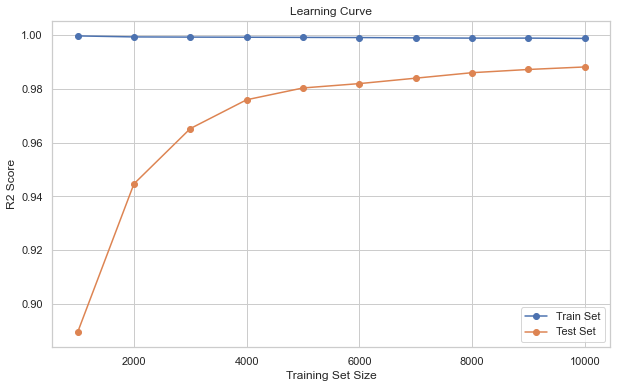

In [279]:
from sklearn.model_selection import learning_curve

# Définissez les tailles de train set que vous souhaitez évaluer
train_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,10000]

# Initialisez le modèle que vous souhaitez évaluer
model = YourModel()  # Remplacez YourModel par le modèle que vous utilisez

# Calculez la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=5, scoring='r2')

# Calculez la moyenne des scores pour l'ensemble d'entraînement et de test
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Tracez la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Train Set')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Test Set')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()


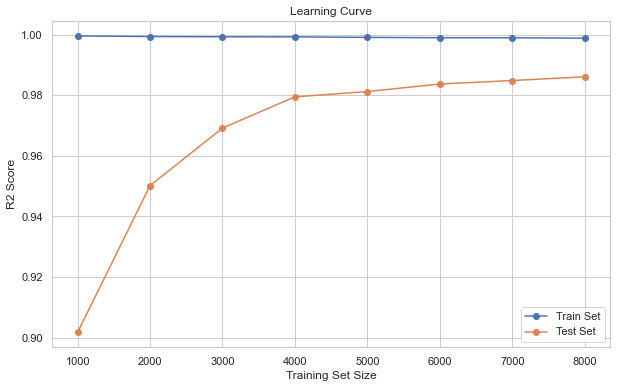

In [280]:
# Définissez les tailles de train set que vous souhaitez évaluer
train_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

# Initialisez le modèle que vous souhaitez évaluer
model = YourModel()  # Remplacez YourModel par le modèle que vous utilisez

# Créez un objet KFold personnalisé
custom_kfold = KFold(n_splits=5, shuffle=True, random_state=seed)  # Personnalisez n_splits, shuffle, et random_state selon vos besoins

# Calculez la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, train_sizes=train_sizes, cv=custom_kfold, scoring='r2')

# Calculez la moyenne des scores pour l'ensemble d'entraînement et de test
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Tracez la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Train Set')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Test Set')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()
